In [55]:
import numpy as np
import matplotlib.pyplot as plt

shape = (100, 16)
n = shape[1]

np.random.seed(10)
X = np.random.randint(-5,6, size=shape) # Integers from -5 to 5
y = np.sum(X, axis=1) # Sum of each row
X = X + np.random.normal(0, .1, shape) # Add noise to input


In [56]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X, y)
reg.score(X, y), reg.coef_

(0.9993316174977624,
 array([0.98231329, 1.00293103, 1.01089872, 0.99780244, 1.01754801,
        1.01399901, 1.01117047, 1.0116978 , 0.97996713, 1.0128416 ,
        1.00504136, 1.01933667, 0.98243754, 0.98514289, 1.0177332 ,
        1.00559587]))

In [10]:
import itertools
import math

def divisive_shap_approx(X, y, model, beta, gamma_n, gamma_d):
    if X.shape[1] > np.emath.logn(beta, n):
        split_S = partition(X,y,model)
        gamma_n = gamma_n*value(X, y, model)
        gamma_d = gamma_d*sum([value(Xi, yi, model) for Xi, yi in split_S])
        return union([divisive_shap_approx(Xi, 
                                           yi, 
                                           model,
                                           beta,
                                           gamma_n, 
                                           gamma_d) for Xi, yi in split_S])
    else:
        shap = shapley_true(X, y, model)
        shap = shap*gamma_n/gamma_d
        return (X, y, shap)

def value(X, y, model):
    if X.size == 0:
        return 0
    else:
        reg = model.fit(X, y)
        return reg.score(X, y)
        

def findsubsets(s, n):
    return list(itertools.combinations(s, n))


def shapley_true(X, y, model):
    """Returns true shapley value of each feature (numpy array)"""
    N = X.shape[1]
    shap = np.zeros(N)
    for i in range(N):
        other_features = set(range(N))
        other_features.remove(i)
        subsets = [subset for j in range(N) for subset in findsubsets(other_features, j)]
        for subset in subsets:
            coeff = math.factorial(len(subset))*math.factorial(N - len(subset) - 1)/math.factorial(N)
            shap[i] += coeff*(value(X[:,list(subset) + [i]], y, model)-value(X[:, list(subset)], y, model))
    return np.array(shap)

def partition(X, y, model):
    """Returns list of tuples: [(X1, Y1), (X2, Y2), ...]"""
    N = X.shape[1]
    return [(X[:,:N//2], y), (X[:,N//2:], y)]

def union(S_split):
    """Returns the union of several sets (Xi, Yi, Shapi)"""
    X = S_split[0][0]
    y = S_split[0][1]
    shap = S_split[0][2]
    for Xi, _, shapi in S_split[1:]:
        X = np.concatenate((X, Xi), axis=1)
        shap = np.concatenate((shap, shapi))
    return (X, y, shap)


In [16]:
def main(X, y, model, beta):
    X2, y2, shap = divisive_shap_approx(X, y, model, beta, 1, 1)
    w = sum(shap)
    vN = value(X, y, model)
    if w != vN:
        if w == 0:
            shap = np.array([vN/X.shape[1]]*X.shape[1])
        gamma = vN/w
        shap = shap*gamma
    return (X2, y2, shap)

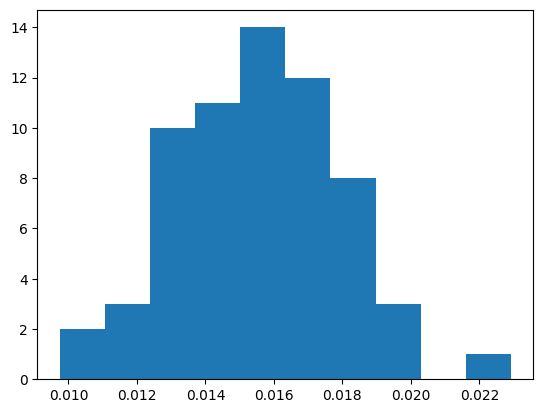

In [88]:
shape = (10000, 64)
n = shape[1]

np.random.seed(10)
X = np.random.randint(-5,6, size=shape) # Integers from -5 to 5
y = np.sum(X, axis=1) # Sum of each row
X = X + np.random.normal(0, .1, shape) # Add noise to input

X, y, shap = main(X, y, LinearRegression(), n**(1/np.sqrt(n)))

plt.hist(shap)
plt.show()


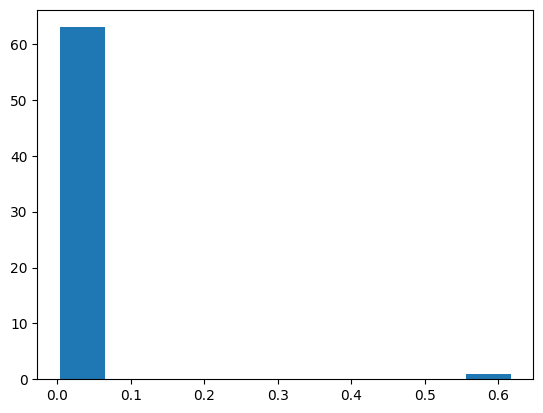

In [89]:
shape = (10000, 64)
n = shape[1]

np.random.seed(10)
X = np.random.randint(-5,6, size=shape) # Integers from -5 to 5
X[:,0] = X[:,0]*10
y = np.sum(X, axis=1) # Sum of each row
X = X + np.random.normal(0, .1, shape) # Add noise to input

X, y, shap = main(X, y, LinearRegression(), n**(1/np.sqrt(n)))

plt.hist(shap)
plt.show()

# Approximating Shapley Values for a real-life Dataset

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
df = pd.read_csv('FIFA 2018 Statistics.csv')
y = (df['Man of the Match'] == "Yes") 
y = [1 if label == True else 0 for label in y]
feature_names = [i for i in df.columns if df[i].dtype in [np.int64, np.int64]]
X = df[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
X

,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Goals in PSO
0,5,40,13,7,3,3,6,3,11,0,78,306,118,22,0,0,0,0
1,0,60,6,0,3,3,2,1,25,2,86,511,105,10,0,0,0,0
2,0,43,8,3,3,2,0,1,7,3,78,395,112,12,2,0,0,0
3,1,57,14,4,6,4,5,1,13,3,86,589,111,6,0,0,0,0
4,0,64,13,3,6,4,5,0,14,2,86,433,101,22,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,1,46,11,1,6,4,4,3,24,5,79,479,148,14,1,0,0,0
124,2,43,12,4,3,5,4,1,5,5,88,510,108,11,1,0,0,0
125,0,57,15,5,7,3,5,0,12,2,92,698,110,5,2,0,0,0
126,4,39,8,6,1,1,2,1,14,1,75,271,99,14,2,0,0,0


In [7]:
from sklearn.linear_model import LinearRegression
#TODO change regression model to classifier
reg = LinearRegression().fit(train_X, train_y)
reg.score(train_X, train_y), reg.coef_

(0.3378130885580428,
 array([ 1.76356991e-01,  1.20888667e-03, -5.02994518e-03,  2.03885167e-02,
         9.69129520e-03, -3.51097571e-02,  4.72775816e-02, -2.57022087e-02,
         1.07743030e-02,  1.45169901e-02,  1.88486335e-03, -1.13927992e-04,
        -6.44581519e-03, -1.07653172e-04, -4.59098258e-02, -2.78698857e-01,
        -3.12701995e-01,  1.33264856e-01]))

### Now we introduce two functions that will use K-means clustering instead of splitting by half.

In [8]:
from sklearn.cluster import KMeans
def main2(X, y, model, beta,k):
    X2, y2, shap = divisive_shap_approx_knn(X, y, model, beta, 1, 1,k)
    w = sum(shap)
    vN = value(X, y, model)
    if w != vN:
        if w == 0:
            shap = np.array([vN/X.shape[1]]*X.shape[1])
        gamma = vN/w
        shap = shap*gamma
    return (X2, y2, shap)
def divisive_shap_approx_knn(X, y, model, beta, gamma_n, gamma_d,k):
    if X.shape[1] > np.emath.logn(beta, n):
        split_S = partition_knn(X,y,model,k)
        gamma_n = gamma_n*value(X, y, model)
        gamma_d = gamma_d*sum([value(Xi, yi, model) for Xi, yi in split_S])
        return union([divisive_shap_approx_knn(Xi, 
                                           yi, 
                                           model,
                                           beta,
                                           gamma_n, 
                                           gamma_d,k) for Xi, yi in split_S])
    else:
        shap = shapley_true(X, y, model)
        shap = shap*gamma_n/gamma_d
        return (X, y, shap)
def partition_knn(X,y,model,k):

    transposed_X = X.T

    kmeans = KMeans(
        init="random",
        n_clusters=k,
        n_init=10,
        max_iter=300,
        random_state=42
    )
    kmeans.fit(transposed_X)
    labels = kmeans.labels_
    X = transposed_X.T
    partitions = []
    X = pd.DataFrame(X)
    for i in range(k):
        partitions.append((np.array(X.iloc[:,labels == i]),y))
      
    return partitions     

Now we calculate exact Shapley values to calculate Mean-Squared Error(MSE) and Root-Mean Squared Error(RMSE)


In [14]:
%%time 
true_shapley = shapley_true(np.array(train_X), np.array(train_y), reg)
print(true_shapley)

[0.16999648 0.00351305 0.01231289 0.03640622 0.0052994  0.02015739
 0.01889732 0.0034261  0.00753081 0.00282818 0.00419999 0.00374287
 0.00380925 0.00176043 0.01024351 0.00525661 0.01237468 0.01605793]
CPU times: user 29min 14s, sys: 7.94 s, total: 29min 22s
Wall time: 29min 32s


In [19]:
import numpy as np
from sklearn.metrics import mean_squared_error
n = train_X.shape[1]
X2, y2, shap = main(np.array(train_X), np.array(train_y), reg, n**(1/np.sqrt(n)))
# Compute the RMSE
mse = mean_squared_error(true_shapley, shap)
rmse = np.sqrt(mse)
print(rmse)

0.006346472569203956


In [21]:
X2, y2, shap_knn = main2(np.array(train_X), np.array(train_y), reg, n**(1/np.sqrt(n)),2)
mse_knn = mean_squared_error(true_shapley, shap_knn)
rmse_knn = np.sqrt(mse_knn)
print(rmse_knn)

0.0497520412181154


0.0497520412181154
0.04821888217914595
0.016432450342648227
0.049785508904246656
0.013738228543978204
0.014007059495093475
0.01381920894011582
0.013971351060804122
0.016824099273877798
0.015584934226295265
0.05294735900451559
0.052281992685438136
0.04961514529101609
0.04979842302344133
0.055832681717661405
0.05324157074925852


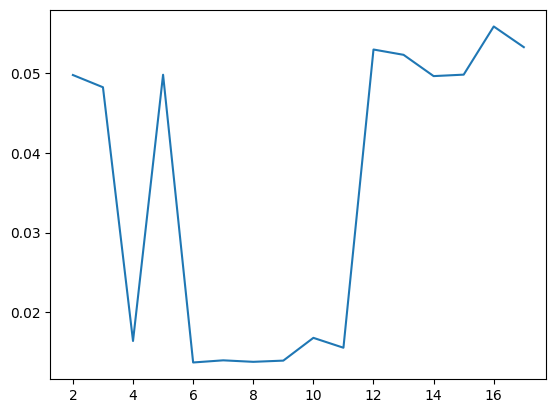

In [30]:
import matplotlib.pyplot as pl 
k_vals = []
rmse_vals = []
for i in range(2,18):
    X2, y2, shap_knn = main2(np.array(train_X), np.array(train_y), reg, n**(1/np.sqrt(n)),i)
    mse_knn_test = mean_squared_error(true_shapley, shap_knn)
    rmse_knn_test = np.sqrt(mse_knn_test)
    k_vals.append(i)
    rmse_vals.append(rmse_knn_test)
    print(rmse_knn_test)

pl.plot(k_vals,rmse_vals)    
